# Задача прогнозирования выживания пассажиров Титаника

In [621]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
import itertools
% matplotlib inline

In [342]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Целевая метка
target = train["Survived"]

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Видим, что записи полные почти по всем характеристикам. И в тестовой, и в обучающей выборке не хватает записей в графе возраст, а также одной записи в тестовой выборке в столбце стоимость билета. При этом минимальное значение стоимости билета равно 0. Это могут быть бесплатные билеты для детей. Проверим этот момент.

In [11]:
train[['Pclass', 'Age', 'Fare', 'Survived']][train['Fare'] == 0]

,Pclass,Age,Fare,Survived
179,3,36.0,0.0,0
263,1,40.0,0.0,0
271,3,25.0,0.0,1
277,2,28.0,0.0,0
302,3,19.0,0.0,0
413,2,28.0,0.0,0
466,2,28.0,0.0,0
481,2,28.0,0.0,0
597,3,49.0,0.0,0
633,1,28.0,0.0,0


Предположение не подтвердилось: бесплатные билеты оказались у пассажиров разных классов обслуживания и разных возрастов. Возможно это были некие рекламные или акционные билеты. Для нашего анализа такие данные неиформативны, поэтому чуть позже мы заменим эти нулевые значения на более репрезентативные.

## Визуальный анализ признаков

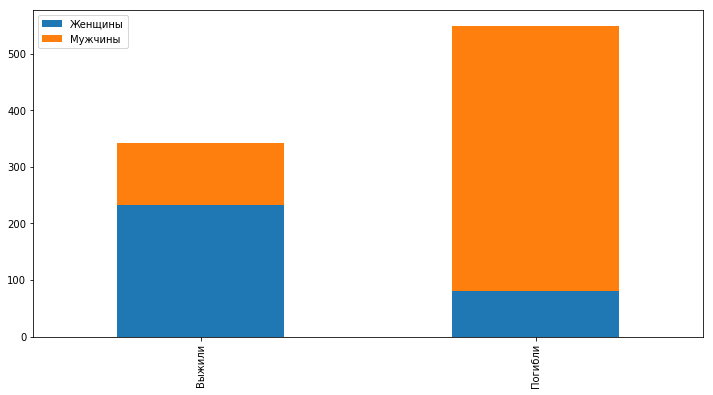

In [19]:
# Распределение выживаемости в зависимости от пола

survived_sex = train[train['Survived'] == 1]["Sex"].value_counts()
dead_sex = train[train['Survived'] == 0]['Sex'].value_counts()
sex_df = pd.DataFrame([survived_sex, dead_sex], index = [u'Выжили', u'Погибли'])
sex_df.columns = [u'Женщины', u'Мужчины']
sex_df.plot(kind = 'bar', stacked = True, figsize = (12, 6));

Очевидна корреляция между полом и выживаемостью

In [20]:
# Для первичного анализа признаков заменим пропущенные значения возраста на медианные
train['Age'] = train['Age'].fillna(train['Age'].median())

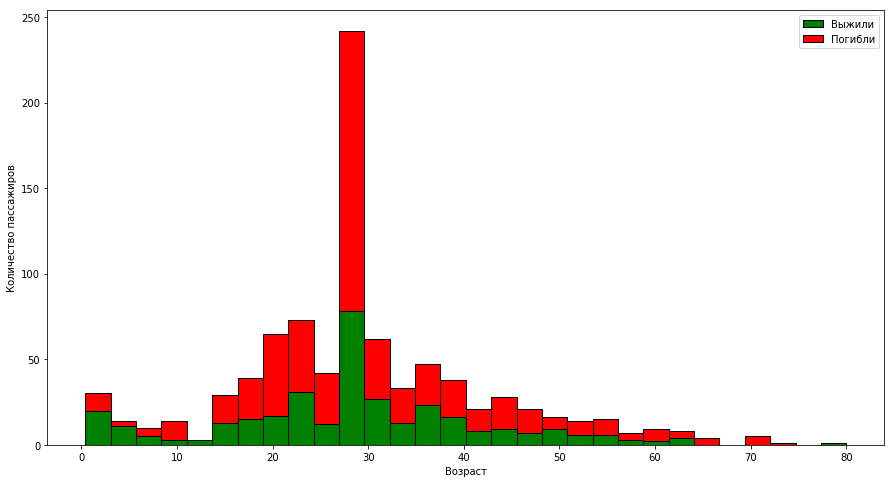

In [21]:
figure = plt.figure(figsize = (15, 8))
plt.hist([train['Age'][train['Survived'] == 1], train['Age'][train['Survived'] == 0]], 
         stacked = True, bins = 30, label = [u'Выжили', u'Погибли'], color = ['g', 'r'], edgecolor = 'black')
plt.xlabel(u'Возраст')
plt.ylabel(u'Количество пассажиров')
plt.legend();

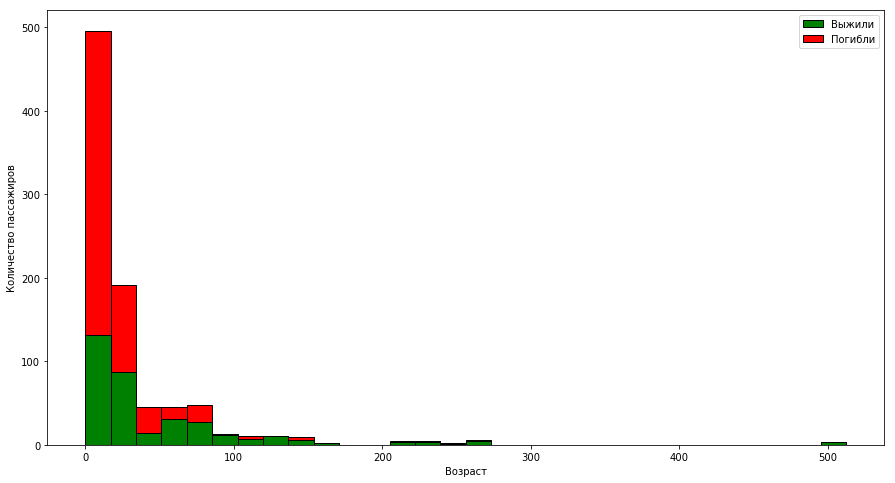

In [514]:
figure = plt.figure(figsize = (15, 8))
plt.hist([train['Fare'][train['Survived'] == 1], train['Fare'][train['Survived'] == 0]], 
         stacked = True, bins = 30, label = [u'Выжили', u'Погибли'], color = ['g', 'r'], edgecolor = 'black')
plt.xlabel(u'Возраст')
plt.ylabel(u'Количество пассажиров')
plt.legend();

По диаграмме видно, что у детей шанс выжить гораздо больше, чем у людей среднего возраста. Скачок количества пассажиров медианного возраста вызван нашим недавним заполнением пустых значений. Вернемся к этому позже

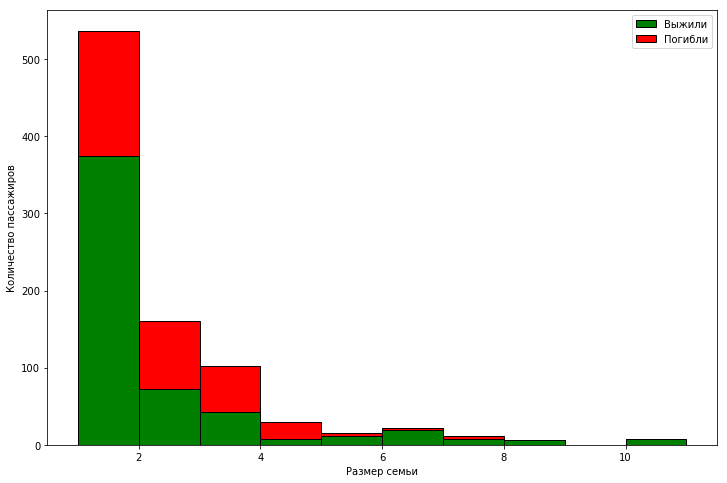

In [344]:
# Введем новый признак - размер семьи и посмотрим на его распределение

train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

figure = plt.figure(figsize = (12, 8))
plt.hist([train['FamilySize'][train['Survived'] == 0], train['FamilySize'][train['Survived'] == 1]], 
         stacked = True, label = [u'Выжили', u'Погибли'], color = ['g', 'r'], edgecolor = 'black')
plt.xlabel(u'Размер семьи')
plt.ylabel(u'Количество пассажиров')
plt.legend();

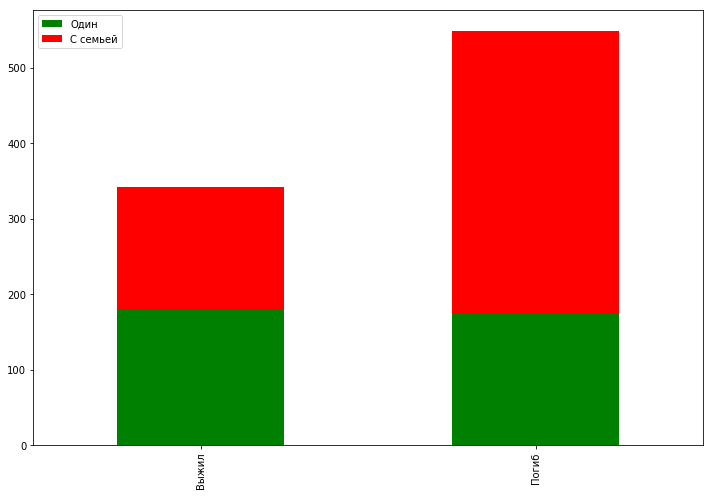

In [345]:
# Отдельно взглянем тяжело ли выжить одному

train['Alone'] = 1
train['Alone'][train['FamilySize'] > 1] = 0

test['Alone'] = 1
test['Alone'][test['FamilySize'] > 1] = 0

plt.figure(figsize = (12, 8))
survived_alone = train[train['Survived'] == 1]['Alone'].value_counts()
dead_alone = train[train['Survived'] == 0]['Alone'].value_counts()
alone_df = pd.DataFrame([survived_alone, dead_alone])
alone_df.index = [u'Выжил', u'Погиб']
alone_df.columns = [u'Один', u'С семьей']
alone_df.plot(kind = 'bar', figsize = (12, 8), color = ['g', 'r'], stacked = True);

У пассажиров, которые путешествовали большими семьями шанс выжить больше, что объяснимо: группе людей выжить проще.

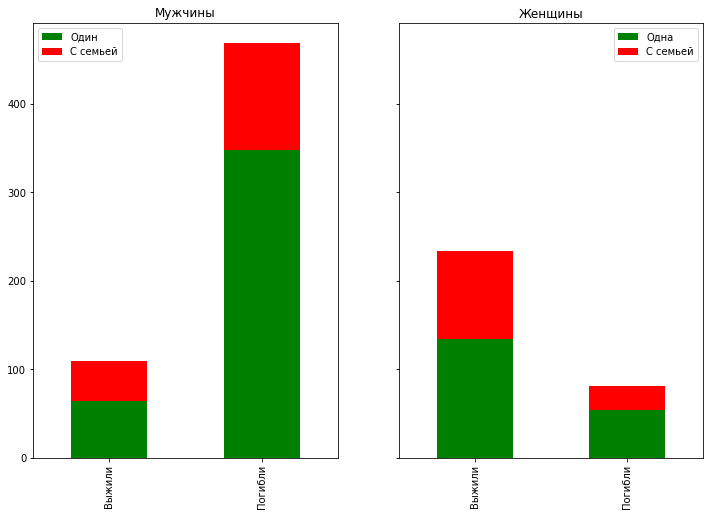

In [68]:
# Разделим эту статистику на женщин и мужчин

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

#plt.figure(figsize = (12, 8))
survived_alone_men = train[train['Survived'] == 1][train['Sex'] == 'male']['Alone'].value_counts()
dead_alone_men = train[train['Survived'] == 0][train['Sex'] == 'male']['Alone'].value_counts()
survived_alone_women = train[train['Survived'] == 1][train['Sex'] == 'female']['Alone'].value_counts()
dead_alone_women = train[train['Survived'] == 0][train['Sex'] == 'female']['Alone'].value_counts()
alone_men = pd.DataFrame([survived_alone_men, dead_alone_men])
alone_women = pd.DataFrame([survived_alone_women, dead_alone_women])
alone_men.index = [u'Выжили', u'Погибли']
alone_men.columns = [u'Один', u'С семьей']
alone_women.index = [u'Выжили', u'Погибли']
alone_women.columns = [u'Одна', u'С семьей']
alone_men.plot(ax = ax1, kind = 'bar', figsize = (12, 8), color = ['g', 'r'], stacked = True)
alone_women.plot(ax = ax2, kind = 'bar', figsize = (12, 8), color = ['g', 'r'], stacked = True)
ax1.set_title(u'Мужчины')
ax2.set_title(u'Женщины');

In [151]:
# Процент выживаемости

def share(value, feature):
    people_survived = float(train[train[value] == feature]['Survived'].value_counts().get_value(1))
    people_dead = float(train[train[value] == feature]['Survived'].value_counts().get_value(0))
    people_survived_share = people_survived / (people_survived + people_dead)
    return people_survived_share

In [152]:
# Процент выживаемости мужчин и женщин

print ('Men ', share('Sex', 'male'))
print ('Women ', share('Sex', 'female'))
print ('Men alone ', share('Sex',  ))

('Men ', 0.18890814558058924)
('Women ', 0.7420382165605095)


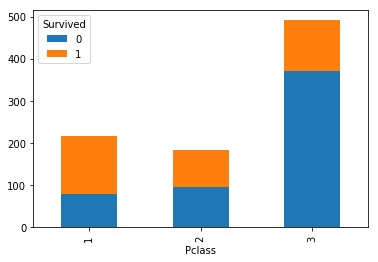

In [130]:
train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

In [346]:
df = train
df = df.append(test)

In [347]:
# Выделим титул каждого пассажира

df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [167]:
df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
the Countess      1
Don               1
Lady              1
Sir               1
Jonkheer          1
Dona              1
Capt              1
Name: Title, dtype: int64

In [348]:
# Объединим разнородные титулы в несколько категорий

Titles = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Rev': 'Officer',
    'Dr': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Mlle': 'Mrs',
    'Ms': 'Mrs',
    'Mme': 'Miss',
    'the Countess': 'Royalty',
    'Don': 'Royalty',
    'Lady': 'Royalty',
    'Sir': 'Royalty',
    'Jonkheer': 'Royalty',
    'Dona': 'Royalty',
    'Capt': 'Officer'
}

df.Title = df.Title.map(Titles)
df.Title.value_counts()

Mr         757
Miss       261
Mrs        201
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

In [169]:
# Теперь вернемся к возрастам. Составим сводную таблицу по медианному возрасту для каждого титула и группы

group_age = df.groupby(['Sex', 'Pclass', 'Title'])
group_age_median = group_age.median()

group_age_median

Age  Alone  FamilySize      Fare  Parch  PassengerId  \
Sex    Pclass Title                                                            
female 1      Miss     30.0    1.0         1.0  106.4250    0.0        505.0   
              Mrs      45.0    0.0         2.0   77.9583    0.0        850.0   
              Officer  49.0    1.0         1.0   25.9292    0.0        797.0   
              Royalty  39.0    1.0         1.0   86.5000    0.0        760.0   
       2      Miss     20.0    0.5         1.5   20.2500    0.0        606.5   
              Mrs      30.0    0.0         2.0   26.0000    0.0        533.0   
       3      Miss     18.0    1.0         1.0    8.0500    0.0        603.5   
              Mrs      31.0    0.0         3.0   15.5000    1.0        668.5   
male   1      Master    6.0    0.0         4.0  134.5000    2.0        803.0   
              Mr       41.5    1.0         1.0   47.1000    0.0        634.0   
              Officer  52.0    1.0         1.0   37.5500    0.0        678.0   
              Royalty  40.0    1.0         1.0   27.7208    0.0        600.0   
       2      Master    2.0    0.0         3.0   26.0000    1.0        550.0   
              Mr       30.0    1.0         1.0   13.0000    0.0        723.5   
              Officer  41.5    1.0         1.0   13.0000    0.0        513.0   
       3      Master    6.0    0.0         5.0   22.3583    1.0        789.0   
              Mr       26.0    1.0         1.0    7.8958    0.0        640.5   

                       SibSp  Survived  
Sex    Pclass Title                     
female 1      Miss       0.0       1.0  
              Mrs        1.0       1.0  
              Officer    0.0       1.0  
              Royalty    0.0       1.0  
       2      Miss       0.0       1.0  
              Mrs        1.0       1.0  
       3      Miss       0.0       0.5  
              Mrs        1.0       0.5  
male   1      Master     1.0       1.0  
              Mr         0.0       0.0  
              Officer    0.0       0.0  
              Royalty    0.0       0.0  
       2      Master     1.0       1.0  
              Mr         0.0       0.0  
              Officer    0.0       0.0  
       3      Master     3.0       0.0  
              Mr         0.0       0.0

In [349]:
# Заменим пустые значения возраста на медианные для соответствующего пола, титула и класса обслуживания

def fillAges(row, grouped_median):
    if row['Sex']=='female' and row['Pclass'] == 1:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 1, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 1, 'Mrs']['Age']
        elif row['Title'] == 'Officer':
             return grouped_median.loc['female', 1, 'Officer']['Age']
        elif row['Title'] == 'Royalty':
             return grouped_median.loc['female', 1, 'Royalty']['Age']

    elif row['Sex']=='female' and row['Pclass'] == 2:
         if row['Title'] == 'Miss':
            return grouped_median.loc['female', 2, 'Miss']['Age']
         elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 2, 'Mrs']['Age']

    elif row['Sex']=='female' and row['Pclass'] == 3:
         if row['Title'] == 'Miss':
            return grouped_median.loc['female', 3, 'Miss']['Age']
         elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 3, 'Mrs']['Age']

    elif row['Sex']=='male' and row['Pclass'] == 1:
         if row['Title'] == 'Master':
            return grouped_median.loc['male', 1, 'Master']['Age']
         elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 1, 'Mr']['Age']
         elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 1, 'Officer']['Age']
         elif row['Title'] == 'Royalty':
            return grouped_median.loc['male', 1, 'Royalty']['Age']

    elif row['Sex']=='male' and row['Pclass'] == 2:
         if row['Title'] == 'Master':
            return grouped_median.loc['male', 2, 'Master']['Age']
         elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 2, 'Mr']['Age']
         elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 2, 'Officer']['Age']

    elif row['Sex']=='male' and row['Pclass'] == 3:
         if row['Title'] == 'Master':
            return grouped_median.loc['male', 3, 'Master']['Age']
         elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 3, 'Mr']['Age']
    
df.Age = df.apply(lambda r : fillAges(r, group_age_median) if np.isnan(r['Age']) 
                                                      else r['Age'], axis=1)

In [350]:
# Заменим пустые значения стоимости билета на медианные для соответствующего пола, титула и класса обслуживания

def fillFares(row, grouped_median):
    if row['Sex']=='female' and row['Pclass'] == 1:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 1, 'Miss']['Fare']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 1, 'Mrs']['Fare']
        elif row['Title'] == 'Officer':
             return grouped_median.loc['female', 1, 'Officer']['Fare']
        elif row['Title'] == 'Royalty':
             return grouped_median.loc['female', 1, 'Royalty']['Fare']

    elif row['Sex']=='female' and row['Pclass'] == 2:
         if row['Title'] == 'Miss':
            return grouped_median.loc['female', 2, 'Miss']['Fare']
         elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 2, 'Mrs']['Fare']

    elif row['Sex']=='female' and row['Pclass'] == 3:
         if row['Title'] == 'Miss':
            return grouped_median.loc['female', 3, 'Miss']['Fare']
         elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 3, 'Mrs']['Fare']

    elif row['Sex']=='male' and row['Pclass'] == 1:
         if row['Title'] == 'Master':
            return grouped_median.loc['male', 1, 'Master']['Fare']
         elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 1, 'Mr']['Fare']
         elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 1, 'Officer']['Fare']
         elif row['Title'] == 'Royalty':
            return grouped_median.loc['male', 1, 'Royalty']['Fare']

    elif row['Sex']=='male' and row['Pclass'] == 2:
         if row['Title'] == 'Master':
            return grouped_median.loc['male', 2, 'Master']['Fare']
         elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 2, 'Mr']['Fare']
         elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 2, 'Officer']['Fare']

    elif row['Sex']=='male' and row['Pclass'] == 3:
         if row['Title'] == 'Master':
            return grouped_median.loc['male', 3, 'Master']['Fare']
         elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 3, 'Mr']['Fare']
    
df.Fare = df.apply(lambda r : fillFares(r, group_age_median) if (r['Fare'] == 0 or np.isnan(r['Fare'])) 
                                                      else r['Fare'], axis=1)

In [351]:
df["Embarked"] = df["Embarked"].fillna('S')

In [ ]:
test["Fare"] = pd.cut(test['Fare'], 4)

In [352]:
data = df.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

In [320]:
class_dummie = pd.get_dummies(data['Pclass'], prefix = 'Class')

In [527]:
# Сумма работы с признаками (для леса)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = pd.concat([train, test])
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Alone'] = 1
df['Alone'][df['FamilySize'] > 1] = 0
df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df.Title = df.Title.map(Titles)
df.Age = df.apply(lambda r : fillAges(r, group_age_median) if np.isnan(r['Age']) 
                                                      else r['Age'], axis=1)
df.Fare = df.apply(lambda r : fillFares(r, group_age_median) if (r['Fare'] == 0 or np.isnan(r['Fare'])) 
                                                      else r['Fare'], axis=1)
df["Embarked"] = df["Embarked"].fillna('S')
df['Cabin'].fillna('U', inplace = True)
decks = {'U': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
df['CabinType'] = df['Cabin'].fillna('U').apply(lambda c: decks.get(c[0]))
dfdrop = df.drop(['Cabin', 'Name', 'PassengerId', 'Survived', 'Ticket'], axis = 1)
data = pd.get_dummies(dfdrop)
Pclass_d = pd.get_dummies(df.Pclass, prefix = "Class")
Family_d = pd.get_dummies(df.FamilySize, prefix = 'FamilySize')
Parch_d = pd.get_dummies(df.Parch, prefix = 'Parch')
SibSp_d = pd.get_dummies(df.SibSp, prefix = 'SibSp')
Cabin_d = pd.get_dummies(df.CabinType, prefix = 'CabinType')
age_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]
fare_bins = [0, 20, 40, 60, 80, 100, 130, 160, 190, 250, 350, 500]
Age_bins = pd.cut(df['Age'], bins = age_bins)
Fare_bins = pd.cut(df['Fare'], bins = fare_bins)
Age_d = pd.get_dummies(Age_bins, prefix = "Age")
Fare_d = pd.get_dummies(Fare_bins, prefix = "Fare")
data = pd.concat([data, Pclass_d, Family_d, Parch_d, SibSp_d, Cabin_d, Age_d, Fare_d], axis = 1)
data = data.drop(['Pclass', 'FamilySize', 'Parch', 'SibSp', 'CabinType', 'Age', 'Fare'], axis = 1)

train_data_full = data.iloc[:891]
test_data_full = data.iloc[891:]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 70 columns):
Alone              1309 non-null int64
Embarked_C         1309 non-null uint8
Embarked_Q         1309 non-null uint8
Embarked_S         1309 non-null uint8
Sex_female         1309 non-null uint8
Sex_male           1309 non-null uint8
Title_Master       1309 non-null uint8
Title_Miss         1309 non-null uint8
Title_Mr           1309 non-null uint8
Title_Mrs          1309 non-null uint8
Title_Officer      1309 non-null uint8
Title_Royalty      1309 non-null uint8
Class_1            1309 non-null uint8
Class_2            1309 non-null uint8
Class_3            1309 non-null uint8
FamilySize_1       1309 non-null uint8
FamilySize_2       1309 non-null uint8
FamilySize_3       1309 non-null uint8
FamilySize_4       1309 non-null uint8
FamilySize_5       1309 non-null uint8
FamilySize_6       1309 non-null uint8
FamilySize_7       1309 non-null uint8
FamilySize_8       1309 non-null uin

In [624]:
# Сумма работы с признаками (для линейных моделей)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = pd.concat([train, test])
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Alone'] = 1
df['Alone'][df['FamilySize'] > 1] = 0
df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df.Title = df.Title.map(Titles)
df.Age = df.apply(lambda r : fillAges(r, group_age_median) if np.isnan(r['Age']) 
                                                      else r['Age'], axis=1)
df.Fare = df.apply(lambda r : fillFares(r, group_age_median) if (r['Fare'] == 0 or np.isnan(r['Fare'])) 
                                                      else r['Fare'], axis=1)
df["Embarked"] = df["Embarked"].fillna('S')
df['Cabin'].fillna('U', inplace = True)
decks = {'U': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
df['CabinType'] = df['Cabin'].fillna('U').apply(lambda c: decks.get(c[0]))
dfdrop = df.drop(['Cabin', 'Name', 'PassengerId', 'Survived', 'Ticket'], axis = 1)
data = pd.get_dummies(dfdrop)
Pclass_d = pd.get_dummies(df.Pclass, prefix = "Class")
Family_d = pd.get_dummies(df.FamilySize, prefix = 'FamilySize')
Parch_d = pd.get_dummies(df.Parch, prefix = 'Parch')
SibSp_d = pd.get_dummies(df.SibSp, prefix = 'SibSp')
Cabin_d = pd.get_dummies(df.CabinType, prefix = 'CabinType')
#age_bins = [0, 10, 20, 30, 40, 60, 80]
#fare_bins = [0, 50, 100, 150, 200, 500]
#Age_bins = pd.cut(df['Age'], bins = age_bins)
#Fare_bins = pd.cut(df['Fare'], bins = fare_bins)
#Age_d = pd.get_dummies(Age_bins, prefix = "Age")
#Fare_d = pd.get_dummies(Fare_bins, prefix = "Fare")
data = pd.concat([data, Pclass_d, Family_d, Parch_d, SibSp_d, Cabin_d], axis = 1)
data = data.drop(['Pclass', 'FamilySize', 'Parch', 'SibSp', 'CabinType'], axis = 1)

scaler = MinMaxScaler()
data['Age'] = scaler.fit_transform(data['Age'])
data['Fare'] = scaler.fit_transform(data['Fare'])

train_data_full = data.iloc[:891]
test_data_full = data.iloc[891:]

In [601]:
train_data_full = data.iloc[:891]
test_data_full = data.iloc[891:]

In [626]:
train_data, test_data, train_target, test_target = train_test_split(train_data_full, 
                                                                    target, test_size = 0.25, 
                                                                    random_state = 1, stratify = target)

In [627]:
n = np.arange(1, 15)
knn_score = []
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    knn.fit(train_data, train_target)
    knn_score.append(accuracy_score(test_target, knn.predict(test_data)))

In [628]:
knn_score

[0.7623318385650224,
 0.80717488789237668,
 0.82959641255605376,
 0.820627802690583,
 0.820627802690583,
 0.82511210762331844,
 0.81165919282511212,
 0.8340807174887892,
 0.820627802690583,
 0.81614349775784756,
 0.80717488789237668,
 0.80717488789237668,
 0.81614349775784756,
 0.82959641255605376]

In [535]:
forest = RandomForestClassifier(n_estimators = 100, random_state = 1)
forest.fit(train_data_full, target)
print ('F_classif')
accuracy_score(test_target, forest.predict(test_data))

F_classif


ValueError: Number of features of the model must match the input. Model n_features is 70 and input n_features is 60 

In [546]:
forest = RandomForestClassifier()
forest.fit(train_data_full.drop(bad_features, axis = 1), target)
print ('Chi2')
accuracy_score(test_target, forest.predict(test_data))

Chi2


0.90134529147982068

In [547]:
cross_val_score(forest, train_data_full.drop(bad_features, axis = 1), y = target, cv = skf).mean()

0.82379349046015715

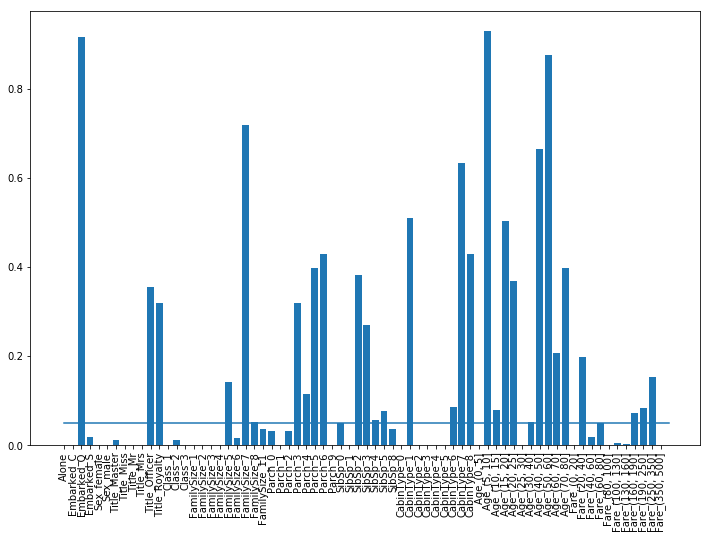

In [549]:
selector = SelectKBest(chi2, k=3)
selector.fit(train_data_full, target)

plt.figure(figsize = (12, 8))
plt.bar(range(len(test_data_full.columns)), selector.pvalues_)
plt.xticks(range(len(test_data_full.columns)), test_data_full.columns, rotation='vertical')
plt.plot([0, 70], [0.05, 0.05])
plt.show()

In [329]:
print (selector.pvalues_ > 0.05)

[False  True False False  True False  True False False False False False
 False False  True  True False False  True  True False False False False
 False False]


In [537]:
bad_features = ['Embarked_Q', 'Title_Officer', 'Title_Royalty', 'FamilySize_5',
               'FamilySize_7', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'SibSp_2', 'SibSp_3', 'CabinType_1',
               'CabinType_7', 'CabinType_8', 'Age_(5, 10]', 'Age_(15, 20]', 'Age_(20, 25]', 'Age_(40, 50]',
               'Age_(50, 60]', 'Age_(60, 70]', 'Age_(70, 80]']

In [282]:
forest = RandomForestClassifier(n_estimators = 80, random_state = 1, max_depth = 5)
forest.fit(train_data_full_forest, target)
accuracy_score(test_target, forest.predict(test_data))

0.84753363228699552

In [542]:
d = {'Survived': forest.predict(test_data_full.drop(bad_features, axis = 1))}
predictions = pd.DataFrame(data = d, index = test['PassengerId'])

In [543]:
predictions.to_csv('prediction_forest.csv')

In [629]:
logit = LogisticRegression(random_state = 1, penalty = 'l2')
logit.fit(train_data, train_target)
accuracy_score(test_target, logit.predict(test_data))

0.82511210762331844

In [512]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [631]:
Cs = np.linspace(2, 6, 100)

logit_search = LogisticRegressionCV(Cs = Cs, random_state = 1, cv = skf, n_jobs = -1)
logit_search.fit(train_data, train_target)

LogisticRegressionCV(Cs=array([ 2.    ,  2.0404, ...,  5.9596,  6.    ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=1, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [632]:
maxnumber = max(itertools.izip(logit_search.scores_[1].mean(axis = 0), itertools.count()))[1]
print ('Максимальное С = %s при доле правильных ответов = %s' % (round(logit_search.Cs[maxnumber], 3), 
                                                round(logit_search.scores_[1].mean(axis = 0)[maxnumber], 4)))

Максимальное С = 6.0 при доле правильных ответов = 0.8203


In [598]:
logit_search.Cs[maxnumber]

2.1616161616161618

In [599]:
train_data_full.drop(logit_bad, axis = 1).head()

,Alone,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Mr,Title_Mrs,Title_Officer,Class_1,Class_3,...,SibSp_1,SibSp_2,SibSp_4,SibSp_5,SibSp_8,CabinType_0,CabinType_4,CabinType_5,CabinType_7,CabinType_8
0,0,1,0,1,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,1,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [641]:
logit_best = LogisticRegression(C = logit_search.Cs[maxnumber])
logit_best.fit(train_data_full.drop(logit_bad, axis = 1), target)
d = {'Survived': logit_best.predict(test_data_full.drop(logit_bad, axis = 1))}
predictions = pd.DataFrame(data = d, index = test['PassengerId'])
predictions.to_csv('Prediction_LogitCV.csv')

In [639]:
cross_val_score(logit_best, train_data_full.drop(logit_bad, axis = 1), y = target, cv = skf).mean()

0.82379349046015715

In [635]:
cross_val_score(logit_best, train_data_full, y = target, cv = skf).mean()

0.81930415263748602

In [636]:
for feature in zip(train_data_full.columns, logit_best.coef_[0]):
    print (feature)

('Age', -2.3778385646790574)
('Fare', 1.7554825273329855)
('Alone', 0.62800962433390206)
('Embarked_C', 0.1291760172771747)
('Embarked_Q', 0.067471695337813428)
('Embarked_S', -0.26486042720496406)
('Sex_female', 1.1374665187698352)
('Sex_male', -1.2056792333597108)
('Title_Master', 2.6534463988372909)
('Title_Miss', -0.53531722236403723)
('Title_Mr', -1.0675913401648207)
('Title_Mrs', 0.24066013888417126)
('Title_Officer', -0.87373315979381005)
('Title_Royalty', -0.48567752998863556)
('Class_1', 0.69802325158980594)
('Class_2', 0.083785035096306235)
('Class_3', -0.85002100127599156)
('FamilySize_1', 0.62800962433390206)
('FamilySize_2', 0.87868445062166101)
('FamilySize_3', 1.1776953330436188)
('FamilySize_4', 1.234284180308217)
('FamilySize_5', -1.7299455459580104)
('FamilySize_6', -1.3192534620641003)
('FamilySize_7', 1.4855857438163567)
('FamilySize_8', -1.4262923242145116)
('FamilySize_11', -0.99698071447719072)
('Parch_0', 0.22375173491951506)
('Parch_1', -0.056625965057962031)
(

In [638]:
logit_bad = ['Alone', 'Embarked_Q', 'Embarked_C', 'Embarked_S', 'Title_Royalty', 
             'Class_2', 'Parch_1', 'FamilySize_2', 'Parch_0', 'Parch_1', 'Parch_2', 
             'Parch_6', 'Parch_9', 'SibSp_3', 'CabinType_0', 'CabinType_1', 'CabinType_2', 
             'CabinType_3', 'CabinType_6']

In [578]:
SVC = LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False)
SVC.fit(train_data, train_target)
accuracy_score(test_target, SVC.predict(test_data))

0.82511210762331844

In [579]:
cross_val_score(SVC_best, train_data_full.drop(bad_features, axis = 1), y = target, cv = skf).mean()

0.73849607182940513

In [565]:
cross_val_score(SVC_best, train_data_full, y = target, cv = skf).mean()

0.81593714927048255

In [560]:
%%time
svm_params = {'C': np.linspace(1e-3, 10, 100)}

svm_search = GridSearchCV(SVC, param_grid=svm_params)
svm_search.fit(train_data, train_target)

CPU times: user 4.1 s, sys: 7.16 s, total: 11.3 s
Wall time: 2.98 s


In [561]:
svm_score = svm_search.best_score_
print ('Лучшее значение доли правильных ответов на кросс-валидации = %s' % round(svm_score, 3))
svm_param = svm_search.best_params_['C']
print ('При С = %s' % round(svm_param, 3))

Лучшее значение доли правильных ответов на кросс-валидации = 0.805
При С = 1.112


In [563]:
SVC_best = LinearSVC(C = svm_search.best_params_['C'])
SVC_best.fit(train_data_full, target)

LinearSVC(C=1.1119999999999999, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [101]:
d = {'Survived': SVC_best.predict(test_set)}
predictions = pd.DataFrame(data = d, index = test_csv['PassengerId'])
predictions.to_csv('Predictions_SVC.csv')

In [426]:
ADA = AdaBoostClassifier()
ADA.fit(train_data, train_target)
accuracy_score(test_target, ADA.predict(test_data))

0.77611940298507465

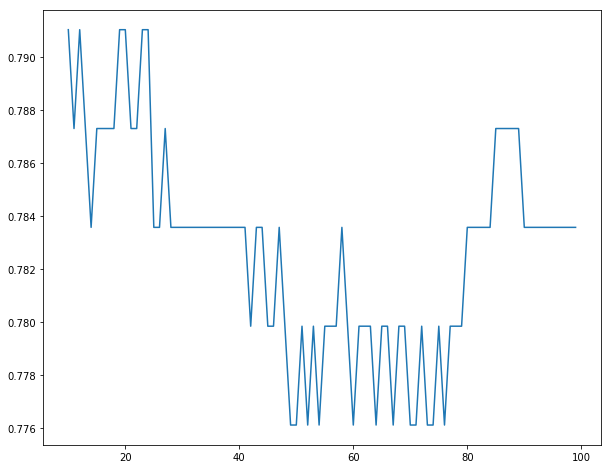

In [427]:
n_ada = np.arange(10, 100)
ada_score = []
for i in n_ada:
    ADA = AdaBoostClassifier(n_estimators = i, random_state = 1)
    ADA.fit(train_data, train_target)
    ada_score.append(accuracy_score(test_target, ADA.predict(test_data)))

fig = plt.figure(figsize = (10, 8))
plt.plot(n_ada, ada_score);

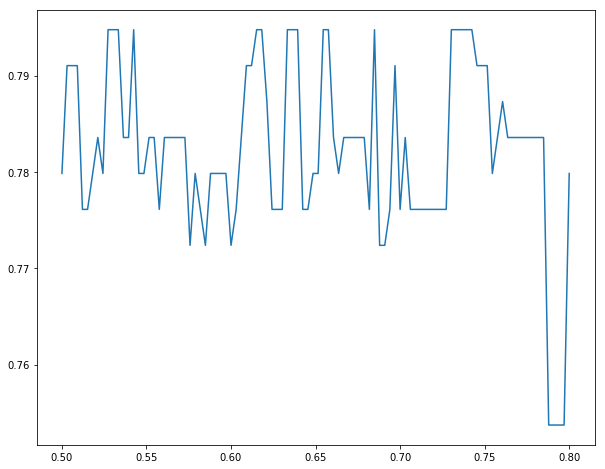

In [229]:
n_LR = np.linspace(0.5, 0.8, 100)
ada_LR_score = []
for i in n_LR:
    ADA = AdaBoostClassifier(n_estimators = 50, random_state = 1, learning_rate = i)
    ADA.fit(train_data, train_target)
    ada_LR_score.append(accuracy_score(test_target, ADA.predict(test_data)))

fig = plt.figure(figsize = (10, 8))
plt.plot(n_LR, ada_LR_score);

In [231]:
maxnumber = max(itertools.izip(ada_LR_score, itertools.count()))[1]
print ('Максимальное Learning rate = %s при доле правильных ответов = %s' % (round(n_LR[maxnumber], 3), 
                                                round(ada_LR_score[maxnumber], 4)))

Максимальное Learning rate = 0.742 при доле правильных ответов = 0.7948


In [232]:
ada_best = AdaBoostClassifier(n_estimators = 50, learning_rate = n_LR[maxnumber])
ada_best.fit(data, target)
d = {'Survived': ada_best.predict(test_set)}
predictions = pd.DataFrame(data = d, index = test_csv['PassengerId'])
predictions.to_csv('Prediction_ADA.csv')

In [428]:
GBC = GradientBoostingClassifier(loss = 'exponential')
GBC.fit(train_data, train_target)
accuracy_score(test_target, GBC.predict(test_data))

0.77985074626865669

Максимальное Learning rate = 2.0 при доле правильных ответов = 0.7873


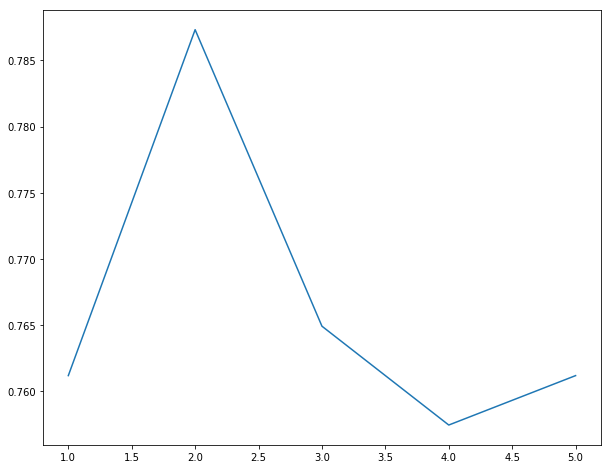

In [256]:
n_GBC = np.arange(1, 6)
GBC_score = []
for i in n_GBC:
    GBC = GradientBoostingClassifier(n_estimators = 11, random_state = 1, learning_rate = 0.549, max_depth = 3,
                            max_features = i)
    GBC.fit(train_data, train_target)
    GBC_score.append(accuracy_score(test_target, GBC.predict(test_data)))

fig = plt.figure(figsize = (10, 8))
plt.plot(n_GBC, GBC_score);

maxnumberGBC = max(itertools.izip(GBC_score, itertools.count()))[1]
print ('Максимальное Learning rate = %s при доле правильных ответов = %s' % (round(n_GBC[maxnumberGBC], 3), 
                                                round(GBC_score[maxnumberGBC], 4)))

Максимальное Learning rate = 14.0 при доле правильных ответов = 0.7836
